# EuroSAT Dataset Applying Custom CNN 

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


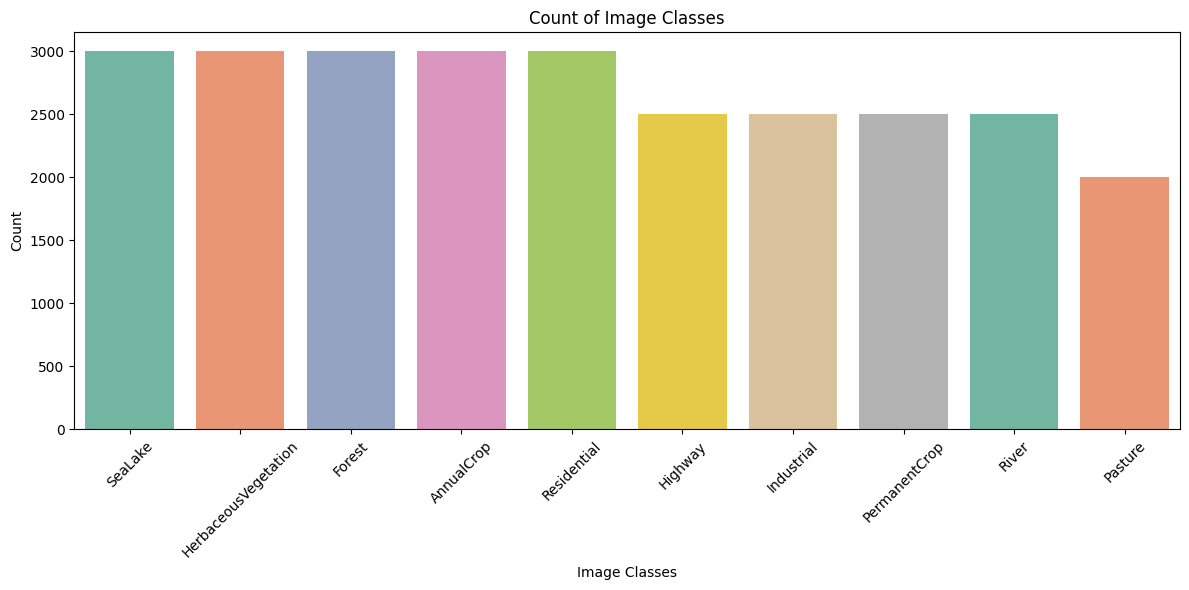

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

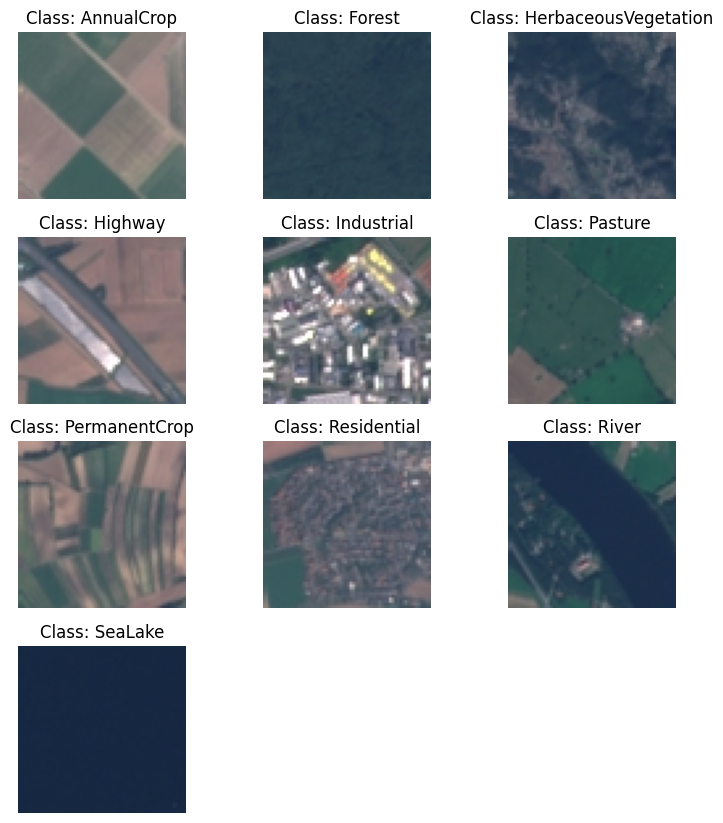

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [27]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [28]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Convolutional Neural Netwirk (G7CNN)

In [30]:
class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # Output: 32x224x224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1),  # 64x112x112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1),  # 128x56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1),  # 256x28x28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(256, 512, 3, padding=1),  # 512x14x14
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x


        

In [31]:
total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
      BatchNorm2d-14          [-1, 256,

### Training

In [32]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.484, loss=1.4] 

Training Loss: 1.396 Acc: 0.484


Validation Loss: 0.852 Acc: 0.689
✅ Best model saved at epoch 1 with validation accuracy: 0.689


Epoch 2/20: 100%|██████████| 296/296 [00:43<00:00,  6.86it/s, acc=0.66, loss=0.977] 

Training Loss: 0.977 Acc: 0.660


Validation Loss: 0.637 Acc: 0.772
✅ Best model saved at epoch 2 with validation accuracy: 0.772


Epoch 3/20: 100%|██████████| 296/296 [00:44<00:00,  6.71it/s, acc=0.711, loss=0.826]

Training Loss: 0.826 Acc: 0.711


Validation Loss: 0.647 Acc: 0.765


Epoch 4/20: 100%|██████████| 296/296 [00:43<00:00,  6.87it/s, acc=0.732, loss=0.764]

Training Loss: 0.764 Acc: 0.732


Validation Loss: 0.614 Acc: 0.798
✅ Best model saved at epoch 4 with validation accuracy: 0.798


Epoch 5/20: 100%|██████████| 296/296 [00:43<00:00,  6.80it/s, acc=0.762, loss=0.696]

Training Loss: 0.696 Acc: 0.762


Validation Loss: 0.527 Acc: 0.817
✅ Best model saved at epoch 5 with validation accuracy: 0.817


Epoch 6/20: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.779, loss=0.649]

Training Loss: 0.649 Acc: 0.779


Validation Loss: 0.418 Acc: 0.850
✅ Best model saved at epoch 6 with validation accuracy: 0.850


Epoch 7/20: 100%|██████████| 296/296 [00:43<00:00,  6.77it/s, acc=0.801, loss=0.588]

Training Loss: 0.588 Acc: 0.801


Validation Loss: 0.656 Acc: 0.768


Epoch 8/20: 100%|██████████| 296/296 [00:43<00:00,  6.82it/s, acc=0.816, loss=0.545]

Training Loss: 0.545 Acc: 0.816


Validation Loss: 0.434 Acc: 0.855
✅ Best model saved at epoch 8 with validation accuracy: 0.855


Epoch 9/20: 100%|██████████| 296/296 [00:43<00:00,  6.80it/s, acc=0.833, loss=0.508]

Training Loss: 0.508 Acc: 0.833


Validation Loss: 0.400 Acc: 0.864
✅ Best model saved at epoch 9 with validation accuracy: 0.864


Epoch 10/20: 100%|██████████| 296/296 [00:43<00:00,  6.82it/s, acc=0.843, loss=0.467]

Training Loss: 0.467 Acc: 0.843


Validation Loss: 0.314 Acc: 0.894
✅ Best model saved at epoch 10 with validation accuracy: 0.894


Epoch 11/20: 100%|██████████| 296/296 [00:42<00:00,  6.91it/s, acc=0.852, loss=0.439]

Training Loss: 0.439 Acc: 0.852


Validation Loss: 0.304 Acc: 0.895
✅ Best model saved at epoch 11 with validation accuracy: 0.895


Epoch 12/20: 100%|██████████| 296/296 [00:43<00:00,  6.88it/s, acc=0.865, loss=0.409]

Training Loss: 0.409 Acc: 0.865


Validation Loss: 0.323 Acc: 0.893


Epoch 13/20: 100%|██████████| 296/296 [00:43<00:00,  6.83it/s, acc=0.875, loss=0.383]

Training Loss: 0.383 Acc: 0.875


Validation Loss: 0.279 Acc: 0.903
✅ Best model saved at epoch 13 with validation accuracy: 0.903


Epoch 14/20: 100%|██████████| 296/296 [00:42<00:00,  6.90it/s, acc=0.884, loss=0.351]

Training Loss: 0.351 Acc: 0.884


Validation Loss: 0.271 Acc: 0.908
✅ Best model saved at epoch 14 with validation accuracy: 0.908


Epoch 15/20: 100%|██████████| 296/296 [00:43<00:00,  6.86it/s, acc=0.887, loss=0.347]

Training Loss: 0.347 Acc: 0.887


Validation Loss: 0.270 Acc: 0.911
✅ Best model saved at epoch 15 with validation accuracy: 0.911


Epoch 16/20: 100%|██████████| 296/296 [00:43<00:00,  6.79it/s, acc=0.891, loss=0.33] 

Training Loss: 0.330 Acc: 0.891


Validation Loss: 0.236 Acc: 0.923
✅ Best model saved at epoch 16 with validation accuracy: 0.923


Epoch 17/20: 100%|██████████| 296/296 [00:43<00:00,  6.74it/s, acc=0.9, loss=0.305]  

Training Loss: 0.305 Acc: 0.900


Validation Loss: 0.236 Acc: 0.918


Epoch 18/20: 100%|██████████| 296/296 [00:42<00:00,  6.89it/s, acc=0.899, loss=0.308]

Training Loss: 0.308 Acc: 0.899


Validation Loss: 0.226 Acc: 0.922


Epoch 19/20: 100%|██████████| 296/296 [00:43<00:00,  6.76it/s, acc=0.906, loss=0.289]

Training Loss: 0.289 Acc: 0.906


Validation Loss: 0.267 Acc: 0.906


Epoch 20/20: 100%|██████████| 296/296 [00:44<00:00,  6.68it/s, acc=0.906, loss=0.281]

Training Loss: 0.281 Acc: 0.906


Validation Loss: 0.269 Acc: 0.901
Training Time: 984.01 seconds ---> 16.40 minutes


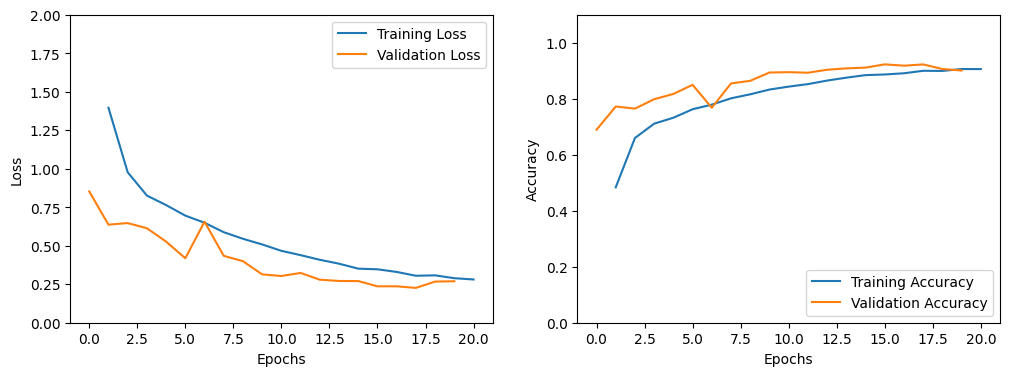

In [33]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [34]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 16) - Validation Loss: 0.233, Validation Accuracy: 0.923


In [35]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.920
Test Time: 5.06 seconds ---> 0.08 minutes


In [36]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       450
           1       0.95      0.97      0.96       450
           2       0.90      0.86      0.88       450
           3       0.88      0.92      0.90       375
           4       0.98      0.94      0.96       375
           5       0.92      0.89      0.91       300
           6       0.78      0.91      0.84       375
           7       0.94      1.00      0.97       450
           8       0.92      0.83      0.88       375
           9       0.98      0.96      0.97       450

    accuracy                           0.92      4050
   macro avg       0.92      0.91      0.92      4050
weighted avg       0.92      0.92      0.92      4050

Class 0 Accuracy: 0.853
Class 1 Accuracy: 0.969
Class 2 Accuracy: 0.867
Class 3 Accuracy: 0.928
Class 4 Accuracy: 0.928
Class 5 Accuracy: 0.890
Class 6 Accuracy: 0.907
Class 7 Accuracy: 0.998
Class 8 Accuracy: 0.851
Cl

### Confusion Matrix

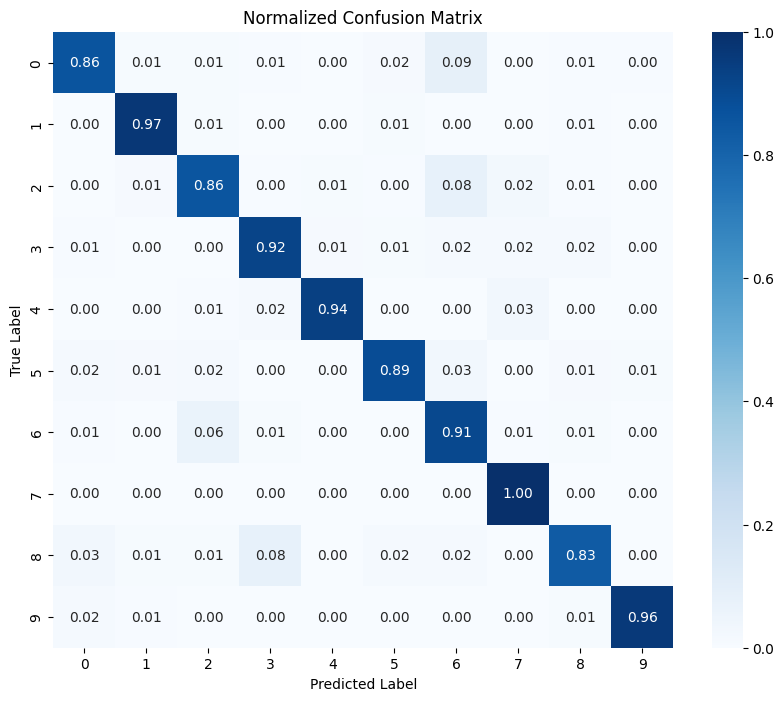

In [37]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

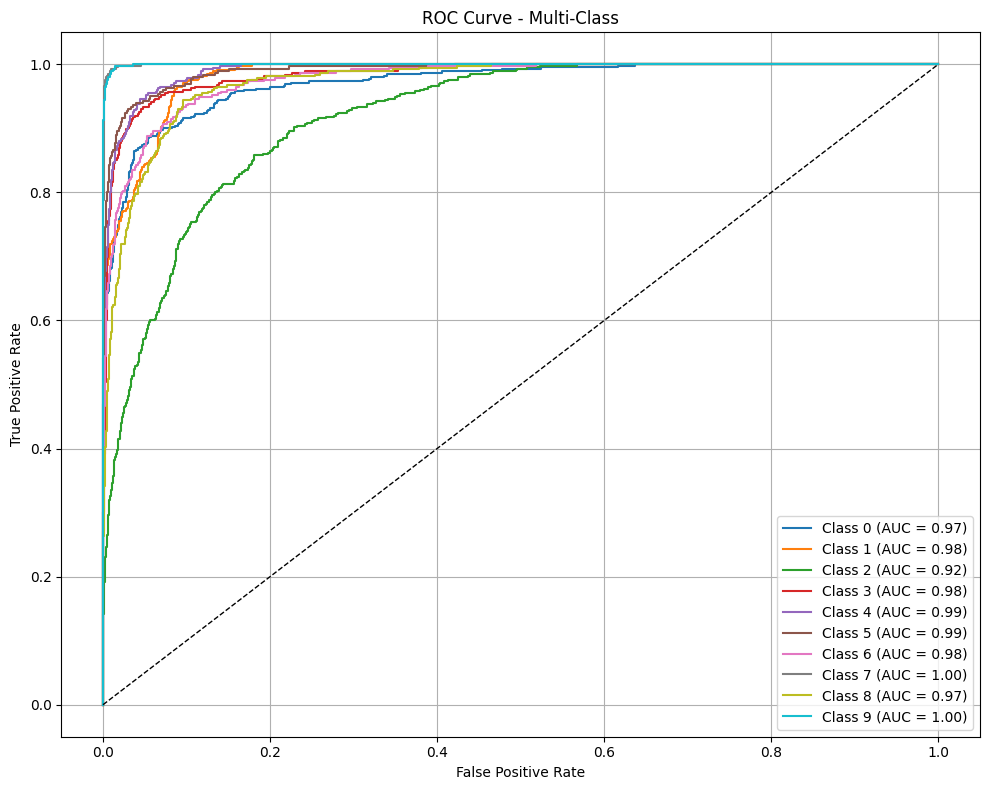

In [38]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()